# Create a geodatabase using UK Census data
This notebook covers one methodology to utilise data from the UK census for geospatial analysis.

## Motivation - Clunky downloading of UK Census data

Like many other data covering whole national populations, accessing and using data from the UK census can be very clunky and frustrating. There are different resources designed to help individuals to download this publically-available data, such the [bulk data download](https://www.ons.gov.uk/census/2011census/2011censusdata/bulkdata) option from the Office for National Statistics (ONS) - the public body who carry out the census in the UK. However, my preferred option for downloading census data is the [Nomis](https://www.nomisweb.co.uk) website - an organisation ran by the University of Durham, on behalf of the ONS.

Despite being my favoured method of downloading data from the UK Census, there is one major flaw in the functionality in downloading UK Census data from the Nomis website - demographic and spatial data have to be downloaded separately.

In other words, this means that you can download a file containing the information on a population living within various Output Areas (OAs - the spatial areas aggregated to present the data and maintain an acceptable amount of anonymity), yet there is no way of knowing where this actually is in the UK. Each OA is given a code, which doesn't directly indicate if it is in London anymore than it does Land's End.

This might not seem like such a big deal. But as a geographer, what is so frustrating is this gives you no scope straight off the bat to make a map of the information you are downloading from the census, to spot patterns or begin to unpick what this actually means. Increasingly, there are more detailed tools that can use location and proximity to compute statistics about data and help to build narratives about how it can be understood.

Thankfully, spatial information is available, in the form of boundary data which can be downloaded separately. The demographic data and boundary data can then be paired together to undertake geospatial analysis (analysis that utilises location). However, this is a faff and it is useful to see a use-case of it in work.

## Context - Leicester, UK
This workbook will focus on merging census data from Leicester, in the UK, at Output Area (OA) level. It takes two forms of data:
* [Demographic data](https://www.nomisweb.co.uk/census/2011/ks201ew) - on the ethic identity of residents of Leicester. In the format of a comma-separated file (csv)
* [Boundary data](https://borders.ukdataservice.ac.uk/bds.html) - of the geometry of each Output Area in Leicester. In the format of a shapefile (shp)

*Please note that in both websites linked above, it is required to manually filter the required subset of data before you download the csv and/or shp files.*

*The demographic data also requires manual cleaning (removal of some rows, and renaming of columns) prior to being read into this workbook. I would recommend you do the same within Excel or alternative csv editor.*

### Common attribute - *oa11cd*
These common attribute of these two types of data - that allows them to be paired together, in what is commonly referred to as a *merge* - is the code given to each Output Area. In these two sets of data, this is stored within a column called **oa11cd** - which refers to the Output Area (oa) related to the 2011 census (11) code (cd).

For example, in Leicester some of the data stored in the oa11cd column looks like this:

*E00068657, E00068658, E00068659, E00068660*

Identifying this common attribute (normally a shared column) is crucial in the merging of geometry data to other data.

So, without further rambling, let's get started creating our merged data!

## Step 1 - Import the necessary modules
Working in Python for this example, we will use tools from 3 different libraries:
* Pandas - to read and manipulate csv files
* Geopandas - to read and manipulate shapefiles
* Matplotlib.pyplot - to plot shapefiles and confirm that the merge has worked correctly

Below you can see them being imported, and given nicknames such that our future code isn't too long-winded

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Step 2 - Reading in the data
Now we can read in the data, from files in our local computer to the workspace we are using - which for this example is this interactive Python notebook.

### 2a - Set file paths
We first need to set the locations of the files we are trying to access. While you can do this within 2b, creating objects storing the file paths helps you to keep track of all that you are doing. And also can help with troubleshooting, should you get errors in your code.

You can see the file paths have been set below, with *fp_eth* relating to the location of the csv file that has the ethnicity data and *fp_shp* relating to the location of the shapefile that contains the boundary data. These file paths can be followed within the GitHub repository.

In [2]:
# Ethnicity data for the city of Leicester from the 2011 UK census - at Output Area (OA) level
fp_eth = "../Example Data - Leicester, UK/Unmerged Data from the ONS/ethnicity_OA_leicester_2011.csv"

# Boundary data for the city of Leicester - at Output Area (OA) level (apologies for the length of this file path)
fp_shp = "../Example Data - Leicester, UK/Unmerged Data from the ONS/2011_OA_Boundaries_Leicester_only-shp-ONS/Output_Areas_(December_2011)_Boundaries_EW_BFC.shp"

### 2b - Read in the data
Now the paths to the files have been set, data from the files themselves can then actually be read in.

As we said in step 1, we will be using commands from different libraries to read in the different types of data that we have: pd (pandas) for the csv file and gpd (geopandas) for the shapefile.

In [3]:
# OA ethnicity data
oa_eth_leicester = pd.read_csv(fp_eth)

# OA boundary data
oa_shp_leicester = gpd.read_file(fp_shp)

### 2c - Confirm data read correctly
Different functions can then be used to get an initial look at what the data you have read in looks like. This can be a good idea, to compare it with what you might expect, or remind yourself exactly what the columns are for future use.

Below I have used the `.head` function to see what the first few observations of the data look like, as well as the `.columns` function where appropriate to list the names of all of the columns when they do not all fit on the output of the head function. Comparing both outputs from the `.head` function, you can see that the common attribute columns taht we have identified do indeed contain the same information - which is why we are going use them as the point of reference to combine the two pieces of data.

The `.plot` function has also been used to show the data contained within the geometry column of the shapefile. You can see the shapes of each of the OAs in Leicester. As you can see though, no further information is avaiable about the people that live within each OA (the shapes are all the same colour), this is the functionality we are aiming to add once the data has been merged.

In [4]:
# Explore what OA ethnicity data looks like
print(oa_eth_leicester.head())

# Print the columns of the OA ethnicity data
print(oa_eth_leicester.columns)

      oa11cd  all    w   p_w  w_b  p_w_b  w_i  p_w_i  w_g  p_w_g  ...  b_c  \
0  E00068657  413  359  86.9  345   83.5    4    1.0    0    0.0  ...    3   
1  E00068658  359  248  69.1  222   61.8    4    1.1    0    0.0  ...    4   
2  E00068659  334  273  81.7  241   72.2    2    0.6    2    0.6  ...    0   
3  E00068660  280  127  45.4  109   38.9    3    1.1    0    0.0  ...    6   
4  E00068661  320  225  70.3  194   60.6    6    1.9    0    0.0  ...    6   

   p_b_c  b_o  p_b_o   o  p_o  o_a  p_o_a  o_o  p_o_o  
0    0.7    3    0.7   0  0.0    0    0.0    0    0.0  
1    1.1    2    0.6   1  0.3    0    0.0    1    0.3  
2    0.0    0    0.0  15  4.5    3    0.9   12    3.6  
3    2.1    1    0.4   7  2.5    1    0.4    6    2.1  
4    1.9    0    0.0   8  2.5    0    0.0    8    2.5  

[5 rows x 48 columns]
Index(['oa11cd', 'all', 'w', 'p_w', 'w_b', 'p_w_b', 'w_i', 'p_w_i', 'w_g',
       'p_w_g', 'w_o', 'p_w_o', 'm', 'p_m', 'm_wbc', 'p_m_wbc', 'm_wba',
       'p_m_wba', 'm_w_a

In [5]:
# Explore what OA boundary data looks like
print(oa_shp_leicester.head())

   OBJECTID     OA11CD    LAD11CD    LAD16CD    LAD16NM     Shape__Are  \
0     66570  E00068657  E06000016  E06000016  Leicester   58692.222687   
1     66571  E00068658  E06000016  E06000016  Leicester   51615.237915   
2     66572  E00068659  E06000016  E06000016  Leicester   98010.396652   
3     66573  E00068660  E06000016  E06000016  Leicester   86993.668503   
4     66574  E00068661  E06000016  E06000016  Leicester  281105.237427   

    Shape__Len                                           geometry  
0  2038.589497  POLYGON ((458598.274 307772.432, 458585.335 30...  
1  1577.523005  POLYGON ((458785.675 307076.320, 458783.317 30...  
2  1752.264912  POLYGON ((458537.000 307386.000, 458544.063 30...  
3  1671.905736  POLYGON ((458253.000 307023.000, 458253.745 30...  
4  2431.710951  POLYGON ((459252.996 306971.333, 459257.693 30...  


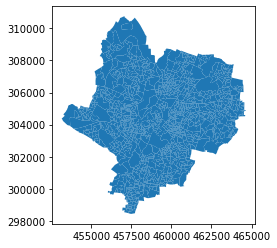

In [6]:
# Plot and show the shapefile contained within the geometry column of the OA boundary data
oa_shp_leicester.plot()
plt.show()

## Step 3 - Undertake any data cleaning
Step 2c can also be really useful for predicting any areas of potential issues in working with the data. I can see such an example, anc will rectify it now, to avoid an error message later on in my code.

I mentioned within the *context* section that identifying the common column was crucial step to merging the data together. For ease, it is easiest to complete this merge when the columns you are using to match up data have the same name attributed to them.

The issue seen in step 2c is that the common column we are using to match up the two datasets - the output area's code - is called *oa11cd* in the oa_eth_leicester object, and *OA11CD* in the oa_shp_leicester object. While these two say the same thing, programming can be a cruel with the slightest variation in text. The difference in capitalisation between the two objects will bring about an error.

While differences in the names of the column can be accounted for while undertaking the merge command, it is easiest to rename one of the columns now, such that the merge command runs first time in the next step.
Below I have done this by renaming the OA code column to *oa11cd* in the shapefile, to match the ethnicity data. I have used the `.columns` function again to show the different from before to after the renaming.

In [7]:
# Before renaming
print(oa_shp_leicester.columns)

Index(['OBJECTID', 'OA11CD', 'LAD11CD', 'LAD16CD', 'LAD16NM', 'Shape__Are',
       'Shape__Len', 'geometry'],
      dtype='object')


In [8]:
oa_shp_leicester.columns = ['OBJECTID', 'oa11cd', 'LAD11CD', 'LAD16CD', 'LAD16NM',
                            'Shape__Are', 'Shape__Len', 'geometry']

In [9]:
# After renaming
print(oa_shp_leicester.columns)

Index(['OBJECTID', 'oa11cd', 'LAD11CD', 'LAD16CD', 'LAD16NM', 'Shape__Are',
       'Shape__Len', 'geometry'],
      dtype='object')


As well as this, we have seen in step 2c that the ethnicity data has tons of columns. When I downloaded this from the Nomis website, I chose to have columns for each Output Area relating to both the raw number of each group and the percentages of each group represented. The percentages columns can be identified through their *'p_'* suffix.

For the intended use of this data, only the raw data is required - therefore, to clean the data up a bit, I can run a single (but long) line of code to 'drop' (remove) the columns that begin with the suffix *p_*.

In [10]:
# 'Drop' (remove) the columns beginning with 'p_' - which relate to the percentages
oa_eth_leicester = oa_eth_leicester.drop(oa_eth_leicester.columns[oa_eth_leicester.columns.str.contains('^p_')], axis=1)

## Step 4 - Merge the data
We can now finally carry out what we have been building up to - merging the demographic data with the geometry data.

This is done using the `.merge` function - with the new object saved as *leicester_oa_eth_shp*. The `on` call within the `.merge` function is used to identify the name of the the common column that we have identified as having the same information in both the demographic and geometry data. Now we have renamed the column in the shapefile, they are both called *oa11cd*.

In [11]:
# Merge the two files together, using the common column of 'oa11cd'
leicester_oa_eth_shp = oa_eth_leicester.merge(oa_shp_leicester, on = 'oa11cd')

Looking at the output of the `.head` function, you can see that the new object contains the columns from both the demographic and geometry data.

In [12]:
# Exploring what this new object looks like
leicester_oa_eth_shp.head()

,oa11cd,all,w,w_b,w_i,w_g,w_o,m,m_wbc,m_wba,...,o,o_a,o_o,OBJECTID,LAD11CD,LAD16CD,LAD16NM,Shape__Are,Shape__Len,geometry
0,E00068657,413,359,345,4,0,10,11,9,0,...,0,0,0,66570,E06000016,E06000016,Leicester,58692.222687,2038.589497,"POLYGON ((458598.274 307772.432, 458585.335 30..."
1,E00068658,359,248,222,4,0,22,25,17,3,...,1,0,1,66571,E06000016,E06000016,Leicester,51615.237915,1577.523005,"POLYGON ((458785.675 307076.320, 458783.317 30..."
2,E00068659,334,273,241,2,2,28,12,1,6,...,15,3,12,66572,E06000016,E06000016,Leicester,98010.396652,1752.264912,"POLYGON ((458537.000 307386.000, 458544.063 30..."
3,E00068660,280,127,109,3,0,15,6,6,0,...,7,1,6,66573,E06000016,E06000016,Leicester,86993.668503,1671.905736,"POLYGON ((458253.000 307023.000, 458253.745 30..."
4,E00068661,320,225,194,6,0,25,27,20,0,...,8,0,8,66574,E06000016,E06000016,Leicester,281105.237427,2431.710951,"POLYGON ((459252.996 306971.333, 459257.693 30..."


Unfortunately there is one more line of code we need to run to make this data usable for geospatial analysis. We need to convert this object into a *geodataframe*, such that it is easily readable by other geospatial tools.

In [13]:
# Converting the dataframe to a geodataframe
leicester_oa_eth_shp = gpd.GeoDataFrame(leicester_oa_eth_shp)

## Step 5 - Confirm merge completed successfully
The easiest way I find to check that a merge, including geometry, has worked as hoped is by plotting the output.

As I have merged the geometry information with demographic information on the ethnic identity of residents, this can be done very easily.

The `.plot` function can be used again, but this time using the `column` call to select a column to use as reference to fill each OA with.

Below I have selected the *a* column to do this - which is the raw number of residents that identify as Asian in Leicester, as part of the 2011 UK Census.

You can see this is shown successfully, with the lower numbers shown in the darkest blues and the higher numbers shown in the brightest greens and yellows.

<AxesSubplot:>

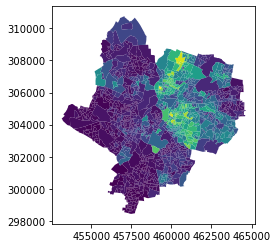

In [14]:
# Plot the merged file, of ethnicity data with boundary geometry
leicester_oa_eth_shp.plot(column = 'a')

## Step 6 - Save new object as a GeoPackage
Now that we have confirmation that this merge has been completed successfully, it is useful to save the newly merged object back to a file such that it can be used within other notebooks, without having to repeat this whole process again.

This is done using the `.to_file` function, where you can set the desired file path of where you would like this new file to be saved.

I have called it *leicester_ethnicity* and have decided to output the merged data as a [GeoPackage](https://www.geopackage.org) - which is a relatively new, but impressively efficient format for storing geographic data and attributes. In order to do this, I have added a crucial *.gpkg* extension at the end of the file path along with telling the command to use the GeoPackage driver to export the file correctly.

In [15]:
type(leicester_oa_eth_shp)

geopandas.geodataframe.GeoDataFrame

In [16]:
# Save the new file as a shapefile, titled 'leicester_ethnicity'
leicester_oa_eth_shp.to_file("../leicester/data/leicester_ethnicity.gpkg", driver = "GPKG")

DriverError: sqlite3_open(../leicester/data/leicester_ethnicity.gpkg) failed: unable to open database file

That should be everything you need to know to have a crack at reading and merging your own UK census data, ready for any geospatial analysis you could imagine!

I hope this notebook helped - to see what I have gone on to use this shapefile to calculate a Kullback–Leibler (KL) divergence profile to measure multiscalar segregation, check out my [kl_divergence](https://github.com/noahbouchier/GSoC-PySAL-21/blob/master/Explanatory%20and%20Interactive%20Workbooks/kl_divergence.ipynb) interactive workbook.

All the best,

Noah